In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cortico_cereb_connectivity.run_model as rm

In [25]:
def heatmap_annotate(df_to_plot, ds_order, ax, ds_order_y=None, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if ds_order_y is None:
        if 'Fusion' in ds_order:
            ds_order_y = [ds for ds in ds_order if ds!='Fusion']
        else:
            ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

In [26]:
method = 'L2reg'
cerebellum = 'MNISymC3'
train_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
eval_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]

df_all = pd.DataFrame()
for ds in train_ds_list:
    eval_data = [ev_ds if ev_ds != "Language" else "Languagelocalizer" for ev_ds in eval_ds_list]
    eval_data = [ev_ds if ev_ds != "Social" else "Socialsocial" for ev_ds in eval_data]

    # load avg models
    df_1 = rm.comb_eval(models=[f'{ds}-avg-Cavg'], eval_data=eval_data, methods=[method], cerebellum=cerebellum)
    df_1["dataset_type"] = 'avg'

    # load group models
    df_2 = rm.comb_eval(models=[f'{ds}-group-Cavg'], eval_data=eval_data, methods=[method], cerebellum=cerebellum)
    df_2["dataset_type"] = 'group'

    df_all = pd.concat([df_all, df_1, df_2], ignore_index=True)

df_avg = df_all[df_all['dataset_type'] == 'avg'].reset_index(drop=True)
df_group = df_all[df_all['dataset_type'] == 'group'].reset_index(drop=True)

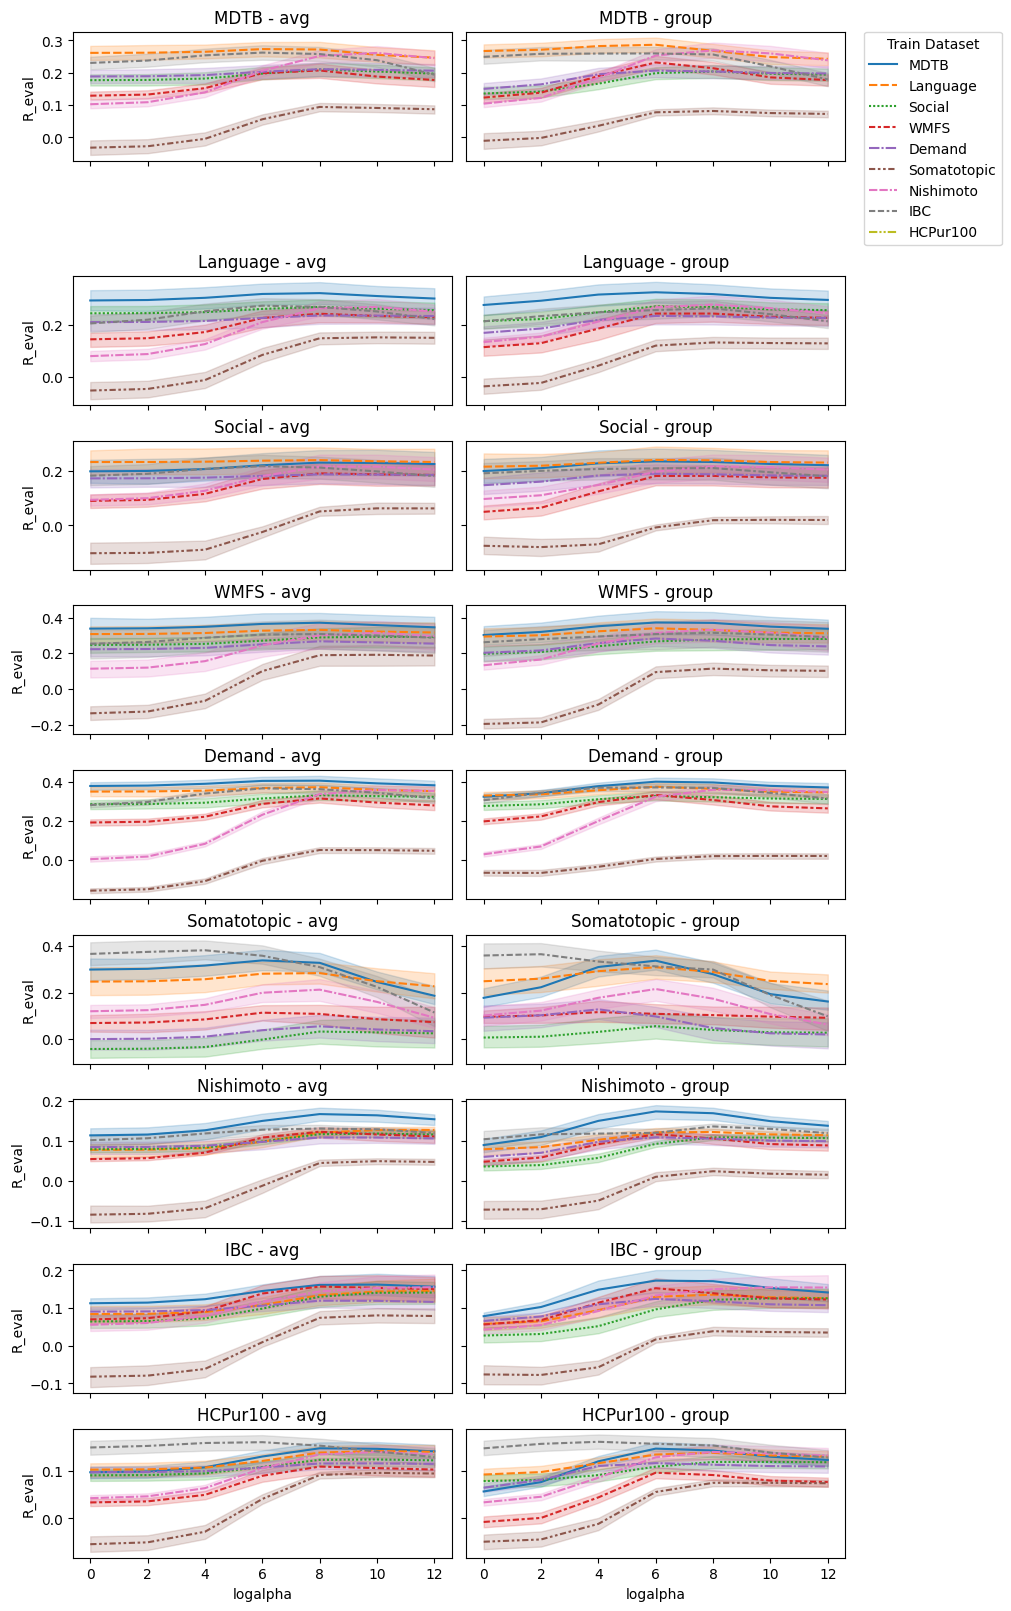

In [32]:
fig, axes = plt.subplots(len(eval_ds_list), 2, figsize=(10, 16), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax_avg = axes[i, 0]
    df_to_plot = df_avg[(df_avg.eval_dataset==ed) & ((df_avg.train_dataset!=ed)
                                                     | (df_avg.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, legend=False, ax=ax_avg)
    ax_avg.set_title(f'{ed} - avg')

    # Right subplot
    ax_group = axes[i, 1]
    df_to_plot = df_group[(df_group.eval_dataset==ed) & ((df_group.train_dataset!=ed)
                                                         | (df_group.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax_group)
    ax_group.set_title(f'{ed} - group')

    if i == 0:
        ax_group.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Train Dataset')
    else:
        ax_group.legend_.remove()

### Find best Hyperparameter

In [27]:
# avg
A = pd.pivot_table(df_avg, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_avg['isbest'] = df_avg.logalpha.values == bestla.loc[df_avg.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.225897  0.227671  0.236499  0.254795  0.263716  0.253790   
Language       0.215748  0.216363  0.220155  0.232625  0.241721  0.235392   
Social         0.166162  0.166936  0.171857  0.189472  0.206215  0.204829   
WMFS           0.102089  0.105398  0.124582  0.173803  0.191890  0.181221   
Demand         0.140958  0.141528  0.144966  0.155928  0.165812  0.163946   
Somatotopic   -0.087212 -0.082315 -0.053658  0.031275  0.089676  0.092777   
Nishimoto      0.062210  0.069194  0.102656  0.178281  0.229090  0.235642   
IBC            0.213164  0.221919  0.242680  0.253788  0.247505  0.229752   

                         
logalpha           12.0  
train_dataset            
MDTB           0.243798  
Language       0.230651  
Social         0.201746  
WMFS           0.174141  
Demand         0.161449  
Somatotopic    0.090548  
Nishimoto      0.223976  
IBC            0.203619

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
Social,8.0
WMFS,8.0
Demand,8.0
Somatotopic,10.0
Nishimoto,10.0
IBC,6.0


In [28]:
# group
A = pd.pivot_table(df_group, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_group['isbest'] = df_group.logalpha.values == bestla.loc[df_group.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.187755  0.206722  0.244275  0.264902  0.258568  0.240413   
Language       0.204224  0.209875  0.228611  0.244915  0.239533  0.227668   
Social         0.145358  0.151137  0.171857  0.195664  0.200175  0.196911   
WMFS           0.083141  0.097642  0.149962  0.193786  0.183051  0.165538   
Demand         0.116298  0.130655  0.160821  0.169699  0.163132  0.155990   
Somatotopic   -0.064325 -0.060734 -0.022593  0.045958  0.062468  0.060679   
Nishimoto      0.070352  0.091760  0.158556  0.223638  0.239896  0.231746   
IBC            0.222536  0.239466  0.248270  0.248911  0.248191  0.224020   

                         
logalpha           12.0  
train_dataset            
MDTB           0.231287  
Language       0.224001  
Social         0.195518  
WMFS           0.160259  
Demand         0.153885  
Somatotopic    0.059334  
Nishimoto      0.218826  
IBC            0.199778

,best_logalpha
train_dataset,
MDTB,6.0
Language,6.0
Social,8.0
WMFS,6.0
Demand,6.0
Somatotopic,8.0
Nishimoto,8.0
IBC,6.0


In [29]:
# Create a subset for best logalpha values
df_avg_best = df_avg[df_avg.isbest]
df_group_best = df_group[df_group.isbest]

### Evaluation Heatmap at best Hyperparameter

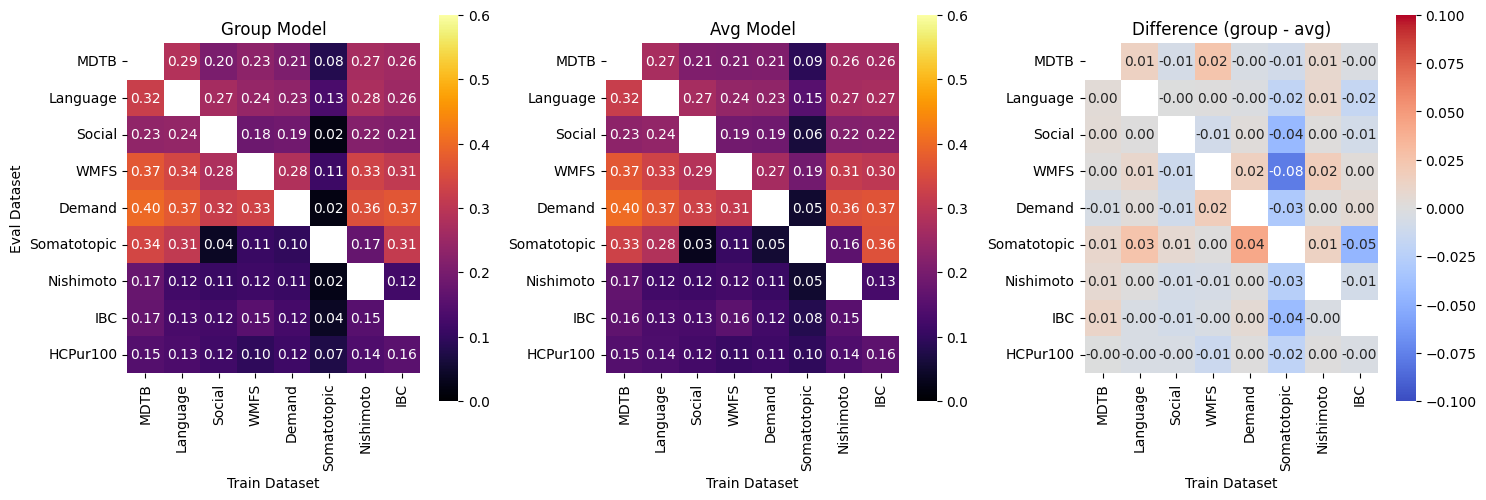

In [30]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

ax = heatmap_annotate(df_group_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[0], value=['R_eval'],
                      cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Group Model')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(df_avg_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[1], value=['R_eval'],
                      cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Avg Model')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(df_avg_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   df_group_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_avg', '_group'))

df_diff['R_eval_diff'] = df_diff['R_eval_group'] - df_diff['R_eval_avg']
ax = heatmap_annotate(df_diff, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[2], value=['R_eval_diff'],
                      cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (group - avg)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

In [33]:
# Add Fusion model
df_fuse_avg = rm.comb_eval(models=["Fusion-avg-Cavg"], methods=[method], eval_data=["HCPur100"], cerebellum='MNISymC3')
df_fuse_avg['train_dataset'] = 'Fusion'
df_avg_on_HCP = df_avg_best[df_avg_best['eval_dataset'] == 'HCPur100'].reset_index(drop=True)
df_avg_on_HCP = pd.concat([df_avg_on_HCP, df_fuse_avg], ignore_index=True)
df_avg_on_HCP['dataset_type'] = 'avg'

df_fuse_group = rm.comb_eval(models=["Fusion-group-Cavg"], methods=[method], eval_data=["HCPur100"], cerebellum='MNISymC3')
df_fuse_group['train_dataset'] = 'Fusion'
df_group_on_HCP = df_group_best[df_group_best['eval_dataset'] == 'HCPur100'].reset_index(drop=True)
df_group_on_HCP = pd.concat([df_group_on_HCP, df_fuse_group], ignore_index=True)
df_group_on_HCP['dataset_type'] = 'group'

df_to_plot = pd.concat([df_avg_on_HCP, df_group_on_HCP], ignore_index=True)

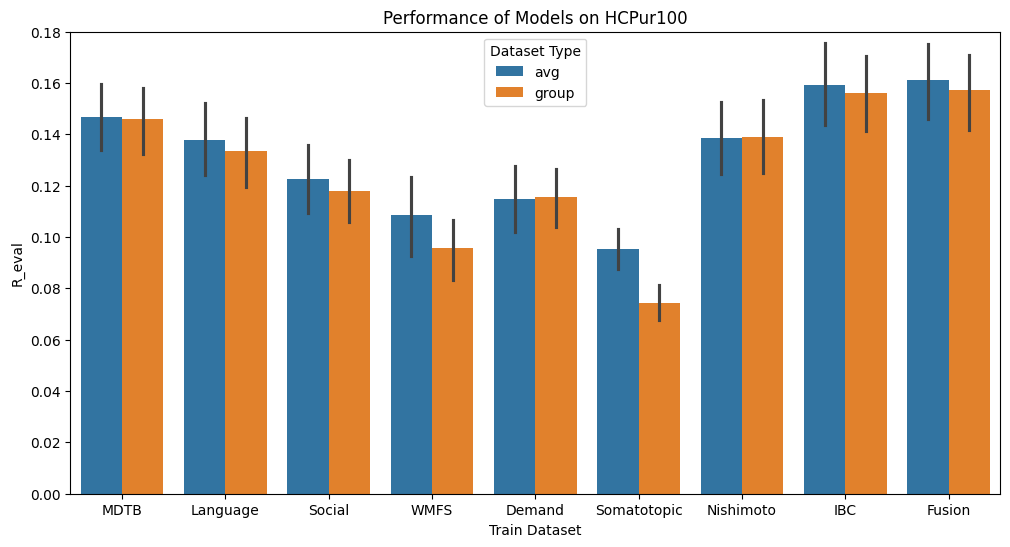

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_to_plot, x='train_dataset', y='R_eval', hue='dataset_type')
plt.title('Performance of Models on HCPur100')
plt.xlabel('Train Dataset')
plt.ylabel('R_eval')
plt.legend(title='Dataset Type')
plt.ylim(0, .18)
plt.show()

### Old data

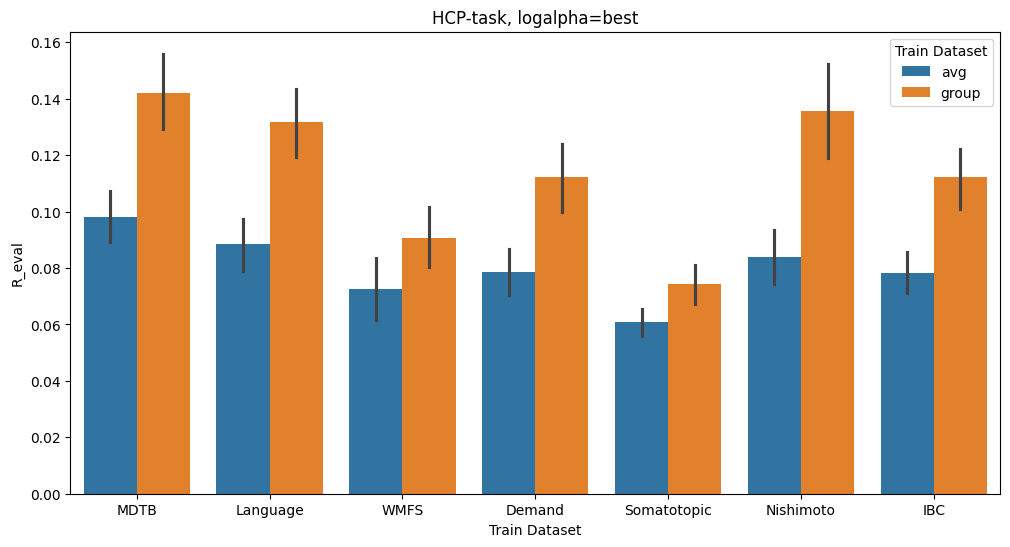

In [23]:
# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='train_dataset', y='R_eval', hue='dataset_type')
plt.title('HCP-task, logalpha=best')
plt.xlabel('Train Dataset')
plt.ylabel('R_eval')
plt.legend(title='Train Dataset')
plt.show()